# Autotune Tutorial

**DISCLAIMER: Most experiments in this notebook require one or more GPUs to keep their runtime a matter of hours.**
**DISCLAIMER: To use our new autotune feature in parallel mode, you need to install [MongoDb](https://docs.mongodb.com/manual/installation/) first.**

In this notebook, we give an in-depth tutorial on `scVI`'s new `autotune` module.

Overall, the new module enables users to perform parallel hyperparemter search for any scVI model and on any number of GPUs/CPUs. Although, the search may be performed sequentially using only one GPU/CPU, we will focus on the paralel case.
Note that GPUs provide a much faster approach as they are particularly suitable for neural networks gradient back-propagation.

Additionally, we provide the code used to generate the results presented in our [Hyperoptimization blog post](https://yoseflab.github.io/2019/07/05/Hyperoptimization/). For an in-depth analysis of the results obtained on three gold standard scRNAseq datasets (Cortex, PBMC and BrainLarge), please to the above blog post. In the blog post, we also suggest guidelines on how and when to use our auto-tuning feature.

In [1]:
import sys

sys.path.append("../../")
sys.path.append("../")

%matplotlib inline

/home/ec2-user


In [2]:
import logging
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from hyperopt import hp

from scvi.dataset import BrainLargeDataset, CortexDataset, LoomDataset, PbmcDataset
from scvi.inference import UnsupervisedTrainer
from scvi.inference.autotune import auto_tune_scvi_model
from scvi.models import VAE

In [ ]:
logger = logging.getLogger("scvi.inference.autotune")
logger.setLevel(logging.WARNING)

In [2]:
def allow_notebook_for_test():
    print("Testing the autotune advanced notebook")

test_mode = False


def if_not_test_else(x, y):
    if not test_mode:
        return x
    else:
        return y


save_path = "data/"
n_epochs = if_not_test_else(1000, 1)
n_epochs_brain_large = if_not_test_else(50, 1)
max_evals = if_not_test_else(100, 1)
reserve_timeout = if_not_test_else(180, 5)
fmin_timeout = if_not_test_else(300, 10)

## Default usage

For the sake of principled simplicity, we provide an all-default approach to hyperparameter search for any `scVI` model.
The few lines below present an example of how to perform hyper-parameter search for `scVI` on the Cortex dataset.

Note that, by default, the model used is `scVI`'s `VAE` and the trainer is the `UnsupervisedTrainer`

Also, the default search space is as follows:
* `n_latent`: [5, 15]
* `n_hidden`: {64, 128, 256}
* `n_layers`: [1, 5]
* `dropout_rate`: {0.1, 0.3, 0.5, 0.7}
* `reconstruction_loss`: {"zinb", "nb"}
* `lr`: {0.01, 0.005, 0.001, 0.0005, 0.0001}

On a more practical note, verbosity varies in the following way:
* `logger.setLevel(logging.WARNING)` will show a progress bar.
* `logger.setLevel(logging.INFO)` will show global logs including the number of jobs done.
* `logger.setLevel(logging.DEBUG)` will show detailed logs for each training (e.g the parameters tested).

This function's behaviour can be customized, please refer to the rest of this tutorial as well as its documentation for information about the different parameters available.

#### Running the hyperoptimization process.

In [ ]:
cortex_dataset = CortexDataset(save_path=save_path)

INFO:scvi.dataset.dataset:File tests/data/expression.bin already downloaded
INFO:scvi.dataset.cortex:Loading Cortex data


In [5]:
best_trainer, trials = auto_tune_scvi_model(
    gene_dataset=cortex_dataset,
    parallel=True,
    exp_key="cortex_dataset",
    train_func_specific_kwargs={"n_epochs": n_epochs},
    max_evals=max_evals,
    reserve_timeout=reserve_timeout,
    fmin_timeout=fmin_timeout,
)

 100%|███████| 100/100 [3:21:15<00:00, 102.45s/it]  

#### Returned objects

The `trials` object contains detailed information about each run.
`trials.trials` is an `Iterable` in which each element corresponds to a single run. It can be used as a dictionary for wich the key "result" yields a dictionnary containing the outcome of the run as defined in our default objective function (or the user's custom version). For example, it will contain information on the hyperparameters used (under the "space" key), the resulting metric (under the "loss" key) or the status of the run.

The `best_trainer` object can be used directly as an scVI `Trainer` object. It is the result of a training on the whole dataset provided using the optimal set of hyperparameters found.

## Custom hyperamater space

Although our default can be a good one in a number of cases, we still provide an easy way to use custom values for the hyperparameters search space.
These are broken down in three categories:
* Hyperparameters for the `Trainer` instance. (if any)
* Hyperparameters for the `Trainer` instance's `train` method. (e.g `lr`)
* Hyperparameters for the model instance. (e.g `n_layers`)

To build your own hyperparameter space follow the scheme used in `scVI`'s codebase as well as the sample below.
Note the various spaces you define, have to follow the `hyperopt` syntax, for which you can find a detailed description [here](https://github.com/hyperopt/hyperopt/wiki/FMin#2-defining-a-search-space).

For example, if you were to want to search over a continuous range of droupouts varying in [0.1, 0.3] and for a continuous learning rate varying in [0.001, 0.0001], you could use the following search space.

In [ ]:
space = {
    "model_tunable_kwargs": {"dropout_rate": hp.uniform("dropout_rate", 0.1, 0.3)},
    "train_func_tunable_kwargs": {"lr": hp.loguniform("lr", -4.0, -3.0)},
}

best_trainer, trials = auto_tune_scvi_model(
    gene_dataset=cortex_dataset,
    space=space,
    parallel=True,
    exp_key="cortex_dataset_custom_space",
    train_func_specific_kwargs={"n_epochs": n_epochs},
    max_evals=max_evals,
    reserve_timeout=reserve_timeout,
    fmin_timeout=fmin_timeout,
)

## Custom objective metric

By default, our autotune process tracks the marginal negative log likelihood of the best state of the model according ot the held-out Evidence Lower BOund (ELBO). But, if you want to track a different early stopping metric and optimize a different loss you can use `auto_tune_scvi_model`'s parameters.

For example, if for some reason, you had a dataset coming from two batches (i.e two merged datasets) and wanted to optimize the hyperparameters for the batch mixing entropy. You could use the code below, which makes use of the `metric_name` argument of `auto_tune_scvi_model`. This can work for any metric that is implemented in the  `Posterior` class you use. You may also specify the name of the `Posterior` attribute you want to use (e.g "train_set").

In [ ]:
pbmc_dataset = PbmcDataset(
    save_path=save_path, save_path_10X=os.path.join(save_path, "10X")
)

In [ ]:
best_trainer, trials = auto_tune_scvi_model(
    gene_dataset=pbmc_dataset,
    metric_name="entropy_batch_mixing",
    posterior_name="train_set",
    parallel=True,
    exp_key="pbmc_entropy_batch_mixing",
    train_func_specific_kwargs={"n_epochs": n_epochs},
    max_evals=max_evals,
    reserve_timeout=reserve_timeout,
    fmin_timeout=fmin_timeout,
)

## Custom objective function

Below, we describe, using one of our Synthetic dataset, how to tune our annotation model `SCANVI` for, e.g, better accuracy on a 20% subset of the labelled data. Note that the model is trained in a semi-supervised framework, that is why we have a labelled and unlabelled dataset. Please, refer to the original [paper](https://www.biorxiv.org/content/10.1101/532895v1) for details on SCANVI!

In this case, as described in our `annotation` notebook we may want to form the labelled/unlabelled sets using batch indices. Unfortunately, that requires a little "by hand" work. Even in that case, we are able to leverage the new autotune module to perform hyperparameter tuning. In order to do so, one has to write his own objective function and feed it to `auto_tune_scvi_model`.

One can proceed as described below.
Note three important conditions:
* Since it is going to be pickled the objective should not be implemented in the "__main__" module, i.e an executable script or a notebook.
* the objective should have the search space as its first attribute and a boolean `is_best_training` as its second.
* If not using a cutstom search space, it should be expected to take the form of a dictionary with the following keys:
    * `"model_tunable_kwargs"`
    * `"trainer_tunable_kwargs"`
    * `"train_func_tunable_kwargs"`

In [ ]:
synthetic_dataset = LoomDataset(
    filename="simulation_1.loom",
    save_path=os.path.join(save_path, "simulation/"),
    url="https://github.com/YosefLab/scVI-data/raw/master/simulation/simulation_1.loom",
)

In [ ]:
from notebooks.utils.autotune_advanced_notebook import custom_objective_hyperopt

In [ ]:
objective_kwargs = dict(dataset=synthetic_dataset, n_epochs=n_epochs)
best_trainer, trials = auto_tune_scvi_model(
    custom_objective_hyperopt=custom_objective_hyperopt,
    objective_kwargs=objective_kwargs,
    parallel=True,
    exp_key="synthetic_dataset_scanvi",
    max_evals=max_evals,
    reserve_timeout=reserve_timeout,
    fmin_timeout=fmin_timeout,
)

## Delayed populating, for very large datasets.

**DISCLAIMER: We don't actually need this for the BrainLarge dataset with 720 genes, this is just an example.**

The fact is that after building the objective function and feeding it to `hyperopt`, it is pickled on to the `MongoWorkers`. Thus, if you pass a loaded dataset as a partial argument to the objective function, and this dataset exceeds 4Gb, you'll get a `PickleError` (Objects larger than 4Gb can't be pickled).

To remedy this issue, in case you have a very large dataset for which you want to perform hyperparameter optimization, you should subclass `scVI`'s `DownloadableDataset` or use one of its many existing subclasses, such that the dataset can be populated inside the objective function which is called by each worker.

In [ ]:
brain_large_dataset = BrainLargeDataset(save_path=save_path, delayed_populating=True)
best_trainer, trials = auto_tune_scvi_model(
    gene_dataset=brain_large_dataset,
    delayed_populating=True,
    parallel=True,
    exp_key="brain_large_dataset",
    max_evals=max_evals,
    trainer_specific_kwargs={
        "early_stopping_kwargs": {
            "early_stopping_metric": "elbo",
            "save_best_state_metric": "elbo",
            "patience": 20,
            "threshold": 0,
            "reduce_lr_on_plateau": True,
            "lr_patience": 10,
            "lr_factor": 0.2,
        }
    },
    train_func_specific_kwargs={"n_epochs": n_epochs_brain_large},
    reserve_timeout=reserve_timeout,
    fmin_timeout=fmin_timeout,
)

# Blog post reproducibility

Below, we provide some code to reproduce the results of our [blog post](https://yoseflab.github.io/2019/07/05/Hyperoptimization/) on hyperparameter search with scVI.
Note, that this can also be used as a tutorial on how to make senss of the output of the autotuning process, the `Trials` object.

## Cortex, Pbmc and BrainLarge hyperparameter optimization

First off, we run the default hyperparameter optimization procedure (default search space, 100 runs) on each of the three dataset of our study:
* The Cortex dataset (done above)
* The Pbmc dataset
* The Brain Large dataset (done above)

In [ ]:
best_trainer, trials = auto_tune_scvi_model(
    gene_dataset=pbmc_dataset,
    parallel=True,
    exp_key="pbmc_dataset",
    max_evals=max_evals,
    train_func_specific_kwargs={"n_epochs": n_epochs},
    reserve_timeout=reserve_timeout,
    fmin_timeout=fmin_timeout,
)

INFO:scvi.inference.autotune:Starting experiment: pbmc_bis
DEBUG:scvi.inference.autotune:Using default parameter search space.
INFO:scvi.inference.autotune:Fixed parameters: 
model: 
{}
trainer: 
{'early_stopping_kwargs': {'early_stopping_metric': 'll', 'save_best_state_metric': 'll', 'patience': 50, 'threshold': 0, 'reduce_lr_on_plateau': False, 'lr_patience': 25, 'lr_factor': 0.2}}
train method: 
{}
INFO:scvi.inference.autotune:Starting parallel hyperoptimization
DEBUG:scvi.inference.autotune:Starting MongoDb process, logs redirected to ./mongo/mongo_logfile.txt.
DEBUG:scvi.inference.autotune:Starting minimization procedure
DEBUG:scvi.inference.autotune:Starting worker launcher
DEBUG:scvi.inference.autotune:Instantiating trials object.
DEBUG:scvi.inference.autotune:Started waiting for fmin Process.
DEBUG:scvi.inference.autotune:Started waiting for Worker Launcher.
DEBUG:scvi.inference.autotune:gpu_ids is None, defaulting to all {n_gpus} GPUs found by torch.
DEBUG:scvi.inference.autot

INFO:hyperopt.mongoexp:job finished: 5ce41122cd2327ac67fdbd41
INFO:scvi.inference.autotune:4 job.s done
INFO:progress_logger:None
DEBUG:hyperopt.mongoexp:job found: SON([('_id', ObjectId('5ce4179ccd2327ac67fdbd42')), ('state', 1), ('tid', 1180), ('spec', None), ('result', SON([('status', 'new')])), ('misc', SON([('tid', 1180), ('cmd', ['domain_attachment', 'FMinIter_Domain']), ('workdir', None), ('idxs', SON([('dropout_rate', [1180]), ('lr', [1180]), ('n_hidden', [1180]), ('n_latent', [1180]), ('n_layers', [1180]), ('reconstruction_loss', [1180])])), ('vals', SON([('dropout_rate', [2]), ('lr', [3]), ('n_hidden', [1]), ('n_latent', [9]), ('n_layers', [1]), ('reconstruction_loss', [0])]))])), ('exp_key', 'pbmc_bis'), ('owner', ['ip-172-31-3-254:19748']), ('version', 0), ('book_time', datetime.datetime(2019, 5, 21, 15, 31, 58, 54000)), ('refresh_time', datetime.datetime(2019, 5, 21, 15, 31, 58, 54000))])
INFO:scvi.inference.autotune:Parameters being tested: 
model: 
{'dropout_rate': 0.5, 

## Handy class to handle the results of each experiment

In the helper, `autotune_advanced_notebook.py` we have implemented a `Benchmarkable` class which will help with things such as benchmark computation, results visualisation in dataframes, etc.

In [ ]:
from notebooks.utils.autotune_advanced_notebook import Benchmarkable

## Make experiment benchmarkables

Below, we use our helper class to store and process the results of the experiments.
It allows us to generate:
* Imputed values from scVI
* Dataframes containing:
    * For each dataset, the results of each trial along with the parameters used.
    * For all dataset, the best result and the associated hyperparameters

In [2]:
results_path = "."

#### Compute imputed values

In [ ]:
cortex = Benchmarkable(
    global_path=results_path, exp_key="cortex_dataset", name="Cortex tuned"
)
cortex.compute_imputed()
pbmc = Benchmarkable(
    global_path=results_path, exp_key="pbmc_dataset", name="Pbmc tuned"
)
pbmc.compute_imputed()
brain_large = Benchmarkable(
    global_path=results_path, exp_key="brain_large_dataset", name="Brain Large tuned"
)
brain_large.compute_imputed()

training: 100%|██████████| 248/248 [01:04<00:00,  3.90it/s]

Median of Median: 2.0815
Mean of Median for each cell: 2.8750
training: 100%|██████████| 160/160 [03:10<00:00,  1.19s/it]

Median of Median: 0.8515
Mean of Median for each cell: 0.9372
training: 100%|██████████| 170/170 [03:40<00:00,  1.29s/it]

Median of Median: 0.8394
Mean of Median for each cell: 0.9246
training:  88%|████████▊ | 44/50 [1:24:35<11:31, 115.28s/it]

## Compute results with default parameters

Below we compute the results obtained with default hyperparameters for each dataset in the study.

#### Train each VAE

In [ ]:
n_epochs_one_shot = if_not_test_else(400, 1)

In [8]:
vae = VAE(cortex_dataset.nb_genes, n_batch=cortex_dataset.n_batches * False)
trainer = UnsupervisedTrainer(
    vae, cortex_dataset, train_size=0.75, use_cuda=True, frequency=1
)
trainer.train(n_epochs=n_epochs_one_shot, lr=1e-3)
with open("trainer_cortex_one_shot", "wb") as f:
    pickle.dump(trainer, f)
with open("model_cortex_one_shot", "wb") as f:
    torch.save(vae, f)

training: 100%|██████████| 400/400 [02:31<00:00,  2.63it/s]


In [9]:
vae = VAE(pbmc_dataset.nb_genes, n_batch=pbmc_dataset.n_batches * False)
trainer = UnsupervisedTrainer(
    vae, pbmc_dataset, train_size=0.75, use_cuda=True, frequency=1
)
trainer.train(n_epochs=n_epochs_one_shot, lr=1e-3)
with open("trainer_pbmc_one_shot", "wb") as f:
    pickle.dump(trainer, f)
with open("model_pbmc_one_shot", "wb") as f:
    torch.save(vae, f)

training: 100%|██████████| 400/400 [15:54<00:00,  2.39s/it]


In [10]:
vae = VAE(brain_large_dataset.nb_genes, n_batch=brain_large_dataset.n_batches * False)
trainer = UnsupervisedTrainer(
    vae, brain_large_dataset, train_size=0.75, use_cuda=True, frequency=1
)
trainer.train(n_epochs=n_epochs_brain_large, lr=1e-3)
with open("trainer_brain_large_one_shot", "wb") as f:
    pickle.dump(trainer, f)
with open("model_brain_large_one_shot", "wb") as f:
    torch.save(vae, f)

training: 100%|██████████| 50/50 [2:28:23<00:00, 178.25s/it]  


Again, we use our helper class to contain, preprocess and access the results of each experiment.

In [11]:
cortex_one_shot = Benchmarkable(
    trainer_fname="trainer_cortex_one_shot",
    model_fname="model_cortex_one_shot",
    name="Cortex default",
    is_one_shot=True,
)
cortex_one_shot.compute_imputed(n_epochs=n_epochs_one_shot)
pbmc_one_shot = Benchmarkable(
    trainer_fname="trainer_pbmc_one_shot",
    model_fname="model_pbmc_one_shot",
    name="Pbmc default",
    is_one_shot=True,
)
pbmc_one_shot.compute_imputed(n_epochs=n_epochs_one_shot)
brain_large_one_shot = Benchmarkable(
    trainer_fname="trainer_brain_large_one_shot",
    model_fname="model_brain_large_one_shot",
    name="Brain Large default",
    is_one_shot=True,
)
brain_large_one_shot.compute_imputed(n_epochs=n_epochs_brain_large)

training: 100%|██████████| 400/400 [02:32<00:00,  2.63it/s]

Median of Median: 2.3032
Mean of Median for each cell: 3.2574
training: 100%|██████████| 400/400 [15:54<00:00,  2.38s/it]

Median of Median: 0.8406
Mean of Median for each cell: 0.9256
training: 100%|██████████| 50/50 [2:27:55<00:00, 177.71s/it]  

Median of Median: 0.0000
Mean of Median for each cell: 0.4581


## Hyperparameter space `DataFrame`

Our helper class allows us to get a dataframe per experiment resuming the results of each trial.

In [6]:
cortex_df = cortex.get_param_df()
cortex_df.to_csv("cortex_df")
cortex_df

,marginal_ll,n_layers,n_hidden,n_latent,reconstruction_loss,dropout_rate,lr,n_epochs,n_params,run index
1,1218.52,1,256,10,zinb,0.1,0.01,248,290816,92
2,1218.7,1,128,12,zinb,0.1,0.01,382,145920,80
3,1219.7,1,256,10,zinb,0.1,0.01,365,290816,85
4,1220.06,1,256,10,zinb,0.1,0.01,275,290816,91
5,1223.09,1,128,10,zinb,0.1,0.01,440,145408,83
6,1223.2,1,128,12,zinb,0.5,0.005,703,145920,38
7,1223.53,1,256,10,zinb,0.1,0.001,514,290816,97
8,1223.94,1,128,12,zinb,0.5,0.01,542,145920,74
9,1224.37,1,128,12,zinb,0.5,0.01,524,145920,76
10,1224.37,1,128,12,zinb,0.5,0.01,497,145920,71


In [7]:
pbmc_df = pbmc.get_param_df()
pbmc_df.to_csv("pbmc_df")
pbmc_df

,marginal_ll,n_layers,n_hidden,n_latent,reconstruction_loss,dropout_rate,lr,n_epochs,n_params,run index
1,1323.79,1,128,10,nb,0.3,0.01,160,859136,29
2,1323.88,1,128,13,nb,0.3,0.005,238,859904,84
3,1324.08,1,128,15,nb,0.3,0.01,172,860416,37
4,1324.1,1,128,14,nb,0.3,0.005,275,860160,68
5,1324.24,1,128,14,nb,0.3,0.005,271,860160,65
6,1324.4,1,128,14,nb,0.3,0.005,196,860160,61
7,1324.53,1,128,13,zinb,0.3,0.001,411,859904,90
8,1324.55,1,128,6,zinb,0.3,0.001,419,858112,75
9,1324.58,1,256,8,nb,0.3,0.01,141,1717248,92
10,1324.62,1,128,11,nb,0.3,0.005,227,859392,70


In [9]:
brain_large_df = brain_large.get_param_df()
brain_large_df.to_csv("brain_large_df")
brain_large_df

,marginal_ll,n_layers,n_hidden,n_latent,reconstruction_loss,dropout_rate,lr,n_epochs,n_params,run index
1,138.77,1,256,8,zinb,0.1,0.001,50,372736,67
2,138.779,1,256,15,zinb,0.1,0.001,46,376320,24
3,138.794,1,256,11,zinb,0.1,0.001,48,374272,73
4,138.798,1,256,8,zinb,0.1,0.001,45,372736,38
5,138.81,1,256,10,zinb,0.1,0.001,49,373760,70
6,138.828,1,256,8,zinb,0.1,0.001,46,372736,66
7,138.852,1,256,8,zinb,0.1,0.001,48,372736,41
8,138.894,1,256,8,zinb,0.1,0.001,42,372736,52
9,138.899,1,256,8,zinb,0.1,0.001,47,372736,26
10,138.902,1,256,12,zinb,0.1,0.005,47,374784,62


# Best run  `DataFrame `

Using the previous dataframes we are able to build one containing the best results along with the results obtained with the default parameters.

In [18]:
cortex_best = cortex_df.iloc[0]
cortex_best.name = "Cortex tuned"
cortex_default = pd.Series(
    [
        cortex_one_shot.best_performance,
        1, 128, 10, "zinb", 0.1, 0.001, 400, None, None
    ],
    index=cortex_best.index
)
cortex_default.name = "Cortex default"
pbmc_best = pbmc_df.iloc[0]
pbmc_best.name = "Pbmc tuned"
pbmc_default = pd.Series(
    [
        pbmc_one_shot.best_performance,
        1, 128, 10, "zinb", 0.1, 0.001, 400, None, None
    ],
    index=pbmc_best.index
)
pbmc_default.name = "Pbmc default"
brain_large_best = brain_large_df.iloc[0]
brain_large_best.name = "Brain Large tuned"
brain_large_default = pd.Series(
    [
        brain_large_one_shot.best_performance,
        1, 128, 10, "zinb", 0.1, 0.001, 400, None, None
    ],
    index=brain_large_best.index
)
brain_large_default.name = "Brain Large default"
df_best = pd.concat(
    [cortex_best,
     cortex_default,
     pbmc_best,
     pbmc_default,
     brain_large_best,
     brain_large_default
    ],
    axis=1
)
df_best = df_best.iloc[np.logical_not(np.isin(df_best.index, ["n_params", "run index"]))]
df_best

,Cortex tuned,Cortex default,Pbmc tuned 16 GPUs,Pbmc default,Brain Large tuned,Brain Large default
marginal_ll,1218.52,1256.03,1323.44,1327.61,138.77,147.088
n_layers,1,1,1,1,1,1
n_hidden,256,128,256,128,256,128
n_latent,10,10,14,10,8,10
reconstruction_loss,zinb,zinb,zinb,zinb,zinb,zinb
dropout_rate,0.1,0.1,0.5,0.1,0.1,0.1
lr,0.01,0.001,0.01,0.001,0.001,0.001
n_epochs,248,400,170,400,50,400


## Handy class to compare the results of each experiment

We use a second handy class to compare these results altogether.
Specifically, the `PlotBenchmarkable` allows to retrieve:
* A `DataFrame` containg the runtime information of each experiment.
* A `DataFrame` comparint the different benchmarks (negative marginal LL, imputation) between tuned and default VAEs.
* For each dataset, a plot aggregating the ELBO histories of each run.

In [55]:
from notebooks.utils.autotune_advanced_notebook import PlotBenchmarkables

In [56]:
tuned_benchmarkables = {
    "cortex": cortex,
    "pbmc": pbmc,
    "brain large": brain_large,
}
one_shot_benchmarkables = {
    "cortex": cortex_one_shot,
    "pbmc": pbmc_one_shot,
    "brain large": brain_large_one_shot
}
plotter = PlotBenchmarkables(
    tuned_benchmarkables=tuned_benchmarkables,
    one_shot_benchmarkables=one_shot_benchmarkables,
)

## Runtime `DataFrame`

In [27]:
df_runtime = plotter.get_runtime_dataframe()
df_runtime

,Nb cells,Nb genes,Total GPU time,Total wall time,Number of trainings,Avg time per training,Avg epochs per training,Number of GPUs,Best epoch,Max epoch
cortex,3005,558,8:58:21.324546,9:02:20.162471,100,323.013,532.08,1,248,1000
pbmc,11990,3346,"1 day, 23:24:59.874052",3:04:12.595907,100,1707,387.01,1,170,1000
brain large,1303182,720,"12 days, 13:55:18.109345",21:38:48.882951,100,10869.2,43.51,16,50,50


## Results `DataFrame` for best runs

In [28]:
def highlight_min(data, color="yellow"):
    attr = "background-color: {}".format(color)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_min = data == data.min()
        return [attr if v else "" for v in is_min]
    else:  # from .apply(axis=None)
        is_min = data == data.min().min()
        return pd.DataFrame(np.where(is_min, attr, ""),
                            index=data.index, columns=data.columns)

In [29]:
df_results = plotter.get_results_dataframe()
styler = df_results.style.apply(highlight_min, axis=0, subset=pd.IndexSlice["cortex", :])
styler = styler.apply(highlight_min, axis=0, subset=pd.IndexSlice["pbmc", :])
styler = styler.apply(highlight_min, axis=0, subset=pd.IndexSlice["brain large", :])
styler

## ELBO Histories plot

In the ELBO histories plotted below, the runs are colored from red to green, where red is the first run and green the last one.

In [ ]:
plt.rcParams["figure.dpi"] = 200
plt.rcParams["figure.figsize"] = (10, 7)

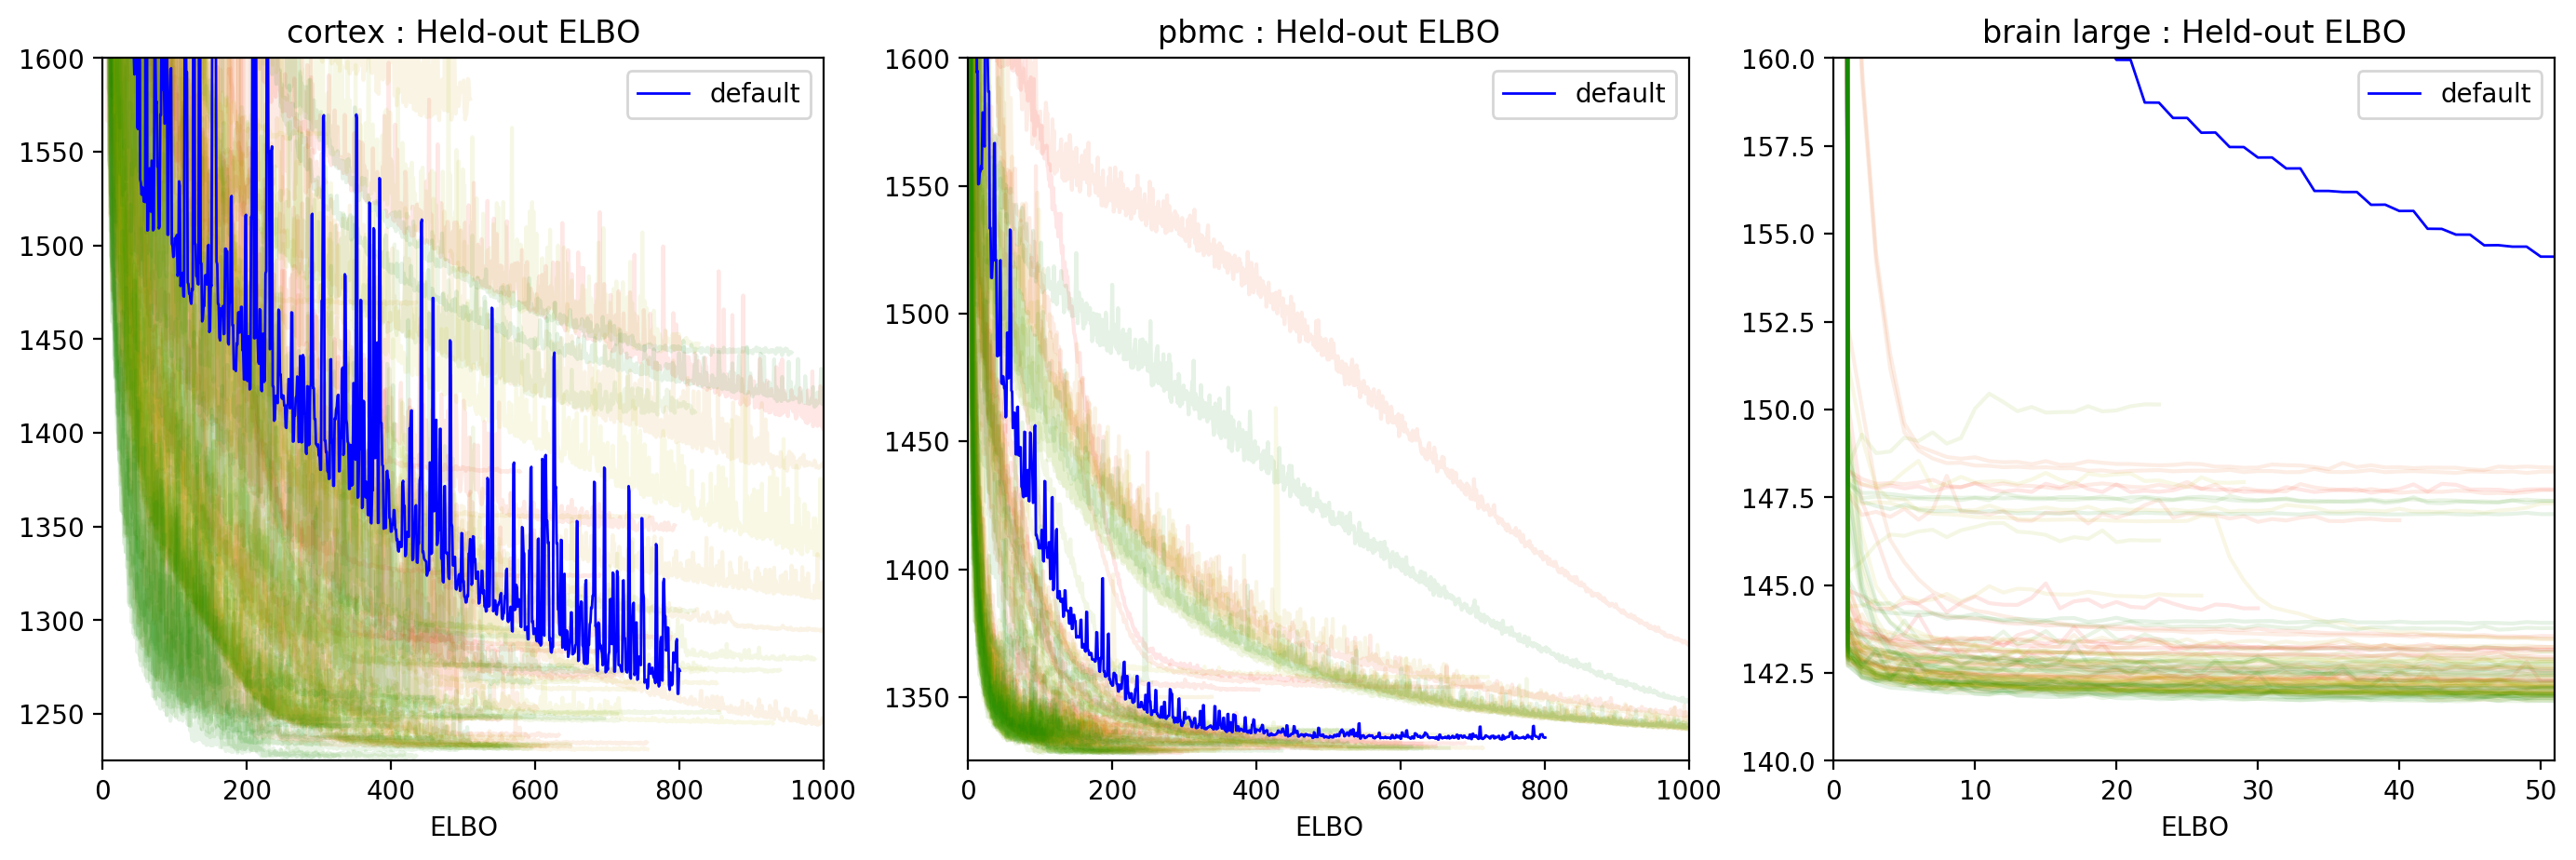

In [62]:
ylims_dict = {
    "cortex": [1225, 1600],
    "pbmc": [1325, 1600],
    "brain large": [140, 160],
}
plotter.plot_histories(figsize=(17, 5), ylims_dict=ylims_dict, filename="elbo_histories_all", alpha=0.1)